# Importing Required Libraries

In [1]:
import pandas as pd 
import numpy as np 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt
from pandas.tools.plotting import lag_plot
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
import seaborn as sns
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

Importing the Dataset

In [2]:
data = pd.read_csv('Champagne.csv')
data.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


Creating a date range

In [3]:
dates = pd.date_range(start='1964-01-01', freq='MS', periods=len(data))
dates[0:5]

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [4]:
data.set_index(dates,inplace=True)
data.drop('Month',axis=1,inplace=True)

# Modeling

In [5]:
train = (data[data.index < '1969-10-01'])
test = (data[data.index >= '1969-10-01'])

# Model 1: Auto Regressive

Auto regression model creates a lag data so that correlation of the created lag is high with the original data.
No.of lag can be defined manually  by seeing ACF plot. By default the algorithm shows the best lag.

In [6]:
model = AR(train)
model_fit = model.fit()

In [7]:
#How many lags considered statistically, what are their beta values
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 11
Coefficients: const        1697.722489
L1.Sales        0.633575
L2.Sales       -0.451075
L3.Sales        0.465719
L4.Sales       -0.643086
L5.Sales        0.492391
L6.Sales       -0.434121
L7.Sales        0.521092
L8.Sales       -0.660454
L9.Sales        0.472919
L10.Sales      -0.481942
L11.Sales       0.760421
dtype: float64


The no of best lag for this data is 11 and all the correlation of the lags with the original sales is listed

In [8]:
# Predicting the test values
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [9]:
print('The first test value in Sales :',test.values[1],'and its Predicted value : ',predictions.values[1])

The first test value in Sales : [10803] and its Predicted value :  10357.725331799871


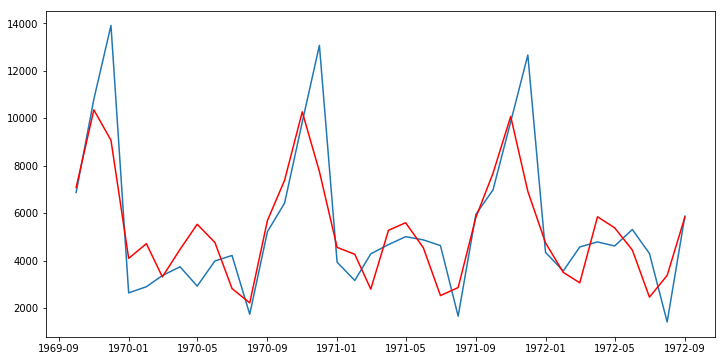

In [10]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [11]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], predictions))
rmse = round(rmse, 3)

In [12]:
# Mean Absolute Percentage Error
abs_error = np.abs(test['Sales']-predictions)
actual = test['Sales']
mape = np.round(np.mean(abs_error/actual),3)
resultsDf = pd.DataFrame({'Method':['Auto Regressive'], 'RMSE': [rmse]})
resultsDf
mape

0.277

In [13]:
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Auto Regressive'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,1864.15,0.277


# Model 2: Auto Regressive Moving Average(ARMA)

The model involves specifying the order for the AR(p) and MA(q) model

In [14]:
# Define the p and q parameters to take any value between 0 and 2
p = range(0, 7)
q = range(0,1)

In [15]:
# Generate all different combinations of p,q
pq = list(itertools.product(p,q))

### Grid Search to get the best p,q parameter

In [16]:
best_aic = np.inf
best_pq = None
temp_model = None
for param in pq: 
    temp_model = ARMA(train,order=param)
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pq = param
print("Best ARMA {} model - AIC:{}".format(best_pq,best_aic))        

Best ARMA (5, 0) model - AIC:1232.5354936732442


In [17]:
# using the best parameter in the model
model = ARMA(train,order=(5,0))
model_fit = model.fit()

In [18]:
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 5
Coefficients: const          4375.077075
ar.L1.Sales       0.636860
ar.L2.Sales      -0.232859
ar.L3.Sales       0.047879
ar.L4.Sales      -0.264159
ar.L5.Sales       0.270975
dtype: float64


In [19]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

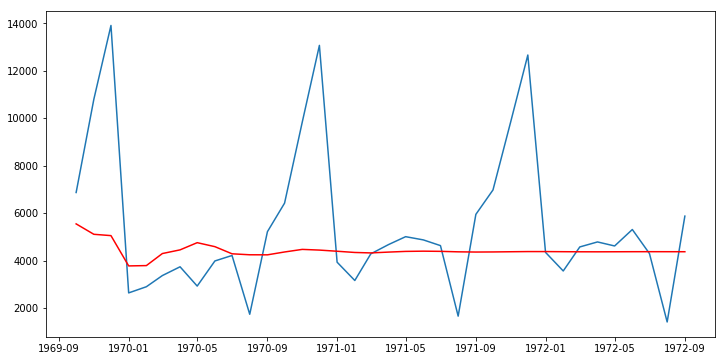

In [20]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [21]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], predictions))
rmse = round(rmse, 3)

In [22]:
# Mean Absolute Percentage Error
abs_error = np.abs(test['Sales']-predictions)
actual = test['Sales']
mape = np.round(np.mean(abs_error/actual),3)

In [23]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Auto Regressive Moving average '], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,1864.15,0.277
0,Auto Regressive Moving average,3185.58,0.384


# Model 3: Autoregressive Integrated Moving Average (ARIMA)

This model involves specifying the order for the AR(p), I(d), and MA(q) models 

In [24]:
train = (data[data.index < '1969-10-01'])
test = (data[data.index >= '1969-10-01'])

In [25]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0,8)
d = range(0,2)
q = range(0,1)

In [26]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

### Grid Search to get the best p,d,q parameter

In [27]:
best_aic = np.inf
best_pdq = None
temp_model = None
for param in pdq:   
    temp_model = ARIMA(train,order=param)
    results = temp_model.fit()
    if results.aic < best_aic:
        best_aic = results.aic
        best_pdq = param 
print("Best ARIMA {} model - AIC:{}".format(best_pdq,best_aic))  

Best ARIMA (4, 1, 0) model - AIC:1221.958623230735


In [28]:
# using the best parameter in the model
model = ARIMA(train,order=(4,1,0))
model_fit = model.fit()

In [29]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

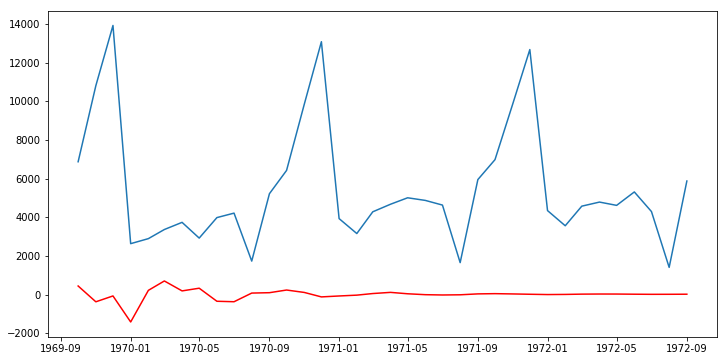

In [30]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [31]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test, predictions))
rmse = round(rmse, 3)

In [32]:
# Mean Absolute Percentage Error
abs_error = np.abs(test['Sales']-predictions)
actual = test['Sales']
mape = np.round(np.mean(np.abs(abs_error/actual)),3)

In [33]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Autoregressive Integrated Moving Average'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,1864.150,0.277
0,Auto Regressive Moving average,3185.580,0.384
0,Autoregressive Integrated Moving Average,6327.009,1.000


# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modeling at the seasonal level. 

In [34]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [35]:
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [36]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Grid Search to get the best p,d,q parameter

In [37]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
for param in pdq:   
    for param_seasonal in seasonal_pdq: 
        temp_model = SARIMAX(train,order=param,seasonal_order = param_seasonal,enforce_invertibility=False,
                             enforce_stationarity=False)
        results = temp_model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_seasonal_pdq = param_seasonal
print("Best ARIMA {} x {} model - AIC:{}".format(best_pdq,best_seasonal_pdq,best_aic))  

C:\Users\manoj\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\manoj\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA (0, 1, 1) x (1, 1, 1, 12) model - AIC:666.1183090127747


In [38]:
# using the best parameter in the model
model = SARIMAX(train,order=(0,1,1),seasonal_order=(1,1,1,12),enforce_invertibility=False,
                             enforce_stationarity=False)
model_fit = model.fit()

In [39]:
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

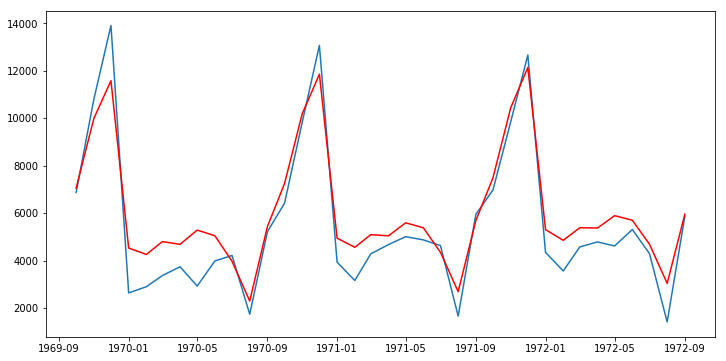

In [40]:
# plot results
plt.figure(figsize=(12,6))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [41]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], predictions))
rmse = round(rmse, 3)

In [42]:
# Mean Absolute Percentage Error
abs_error = np.abs(test['Sales']-predictions)
actual = test['Sales']
mape = np.round(np.mean(np.abs(abs_error/actual)),3)

In [43]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Seasonal Autoregressive Integrated Moving Average'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf.index = [i for i in range(len(resultsDf))]
resultsDf

,Method,RMSE,MAPE
0,Auto Regressive,1864.150,0.277
1,Auto Regressive Moving average,3185.580,0.384
2,Autoregressive Integrated Moving Average,6327.009,1.000
3,Seasonal Autoregressive Integrated Moving Average,1035.182,0.235


### Plot of Champagne Sales with Test and Prediction along with Train

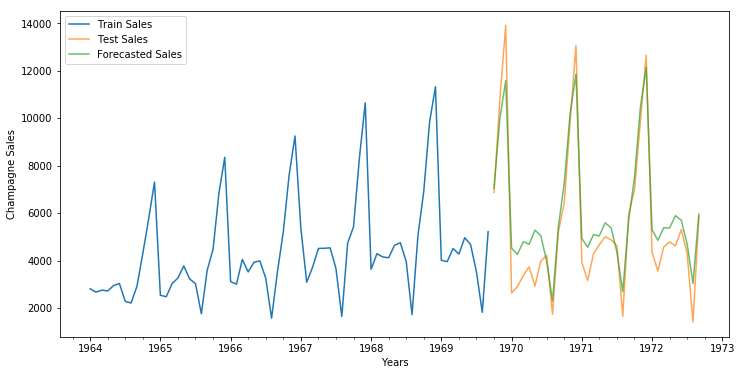

In [44]:
axis = train['Sales'].plot(label='Train Sales', figsize=(12, 6))
test['Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
predictions.plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Champagne Sales')
plt.legend(loc='best')
plt.show()
plt.close()

### Inference:
#####   AR model           -  AR model has given good RMSE score as well as Mape since it captures the correlation in the Sales.   
#####   ARMA model      - ARMA model has also performed well but it didn't capture the seasonality well.   
#####   ARIMA model     - ARIMA model has failed to capture the seasonality so it gives the high error and RMSE score.   
#####   SARIMA model  - SARIMA model has captured the seasonality of the data as well as the trend of the data with the residuals so among all SARIMA has provided the best results